In [1]:
###SASSIE ALTO_ALAMO DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests 

##LOCAL DIRECTORY TO ALTO/ALAMO DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/ALAMO_ALTO/'

##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/sea_ice/'
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)

##LOCAL DIRECTORY TO SHIP TRACK DATA
ship_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG/SASSIE_Fall_2022_Shipboard_TSG.nc'
    
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/ALAMO_ALTO/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)


In [2]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
files = sorted(glob.glob(dir_in + '/*.nc'))
for file in files:
    ##SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
    ds = xr.open_dataset(file)
    #print(ds)
    
    ##SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
    variable_info = ds.time
    #print(variable_info)

In [3]:
def define_variable_attributes(var):
    if var =='salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var =='temperature':
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    return colormap,var_label

In [4]:
#PLOT THE PATHS OF THE FLOATS
def map_float_paths(ship_track=True,bathymetry_data=True,ice_data=False):

    ##CREATE A MAP WITH LAND AND CITY MARKERS  
    latmin = 70
    latmax =74
    lonmin=-157
    lonmax=-144    
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')

    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) 
    ax.set_title('ALTO/ALAMO Float Paths',fontsize=22,pad=1) 
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
    plt.legend(loc=2)
    
    ##OPTIONAL MAP ADD-ONs
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
        
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        start_time = pd.to_datetime(min(xr.open_dataset(files[0]).time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        end_time = pd.to_datetime(max(xr.open_dataset(files[0]).time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
    
        
    #LOAD AND APPLY FLOAT DATA
    for file in files: 
        ds = xr.open_dataset(file)
        float_time = np.squeeze(ds['time'])
        float_lat = np.squeeze(ds['latitude'])
        float_lon = np.squeeze(ds['longitude'])
        casts = ax.scatter(float_lon,float_lat,s = 10,
                           c = float_time,cmap = 'jet',
                           transform=cartopy.crs.PlateCarree(),zorder=2,
                          vmin=min(xr.open_dataset(files[0]).time.values), vmax=max(xr.open_dataset(files[0]).time.values))

    cbar = fig.colorbar(casts, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    cbar_tick_array=(np.linspace(min(xr.open_dataset(files[0]).time.values).astype('int64'),max(xr.open_dataset(files[0]).time.values).astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'map/'):
        os.makedirs(fig_dir+'map/')
    
    print('Saving Output Image:  '+fig_dir+'map/ALTO_ALAMO_paths.png')
    plt.savefig(fig_dir+'map/ALTO_ALAMO_paths.png',dpi='figure',format='png')
    
    


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/ALAMO_ALTO/map/ALTO_ALAMO_paths.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


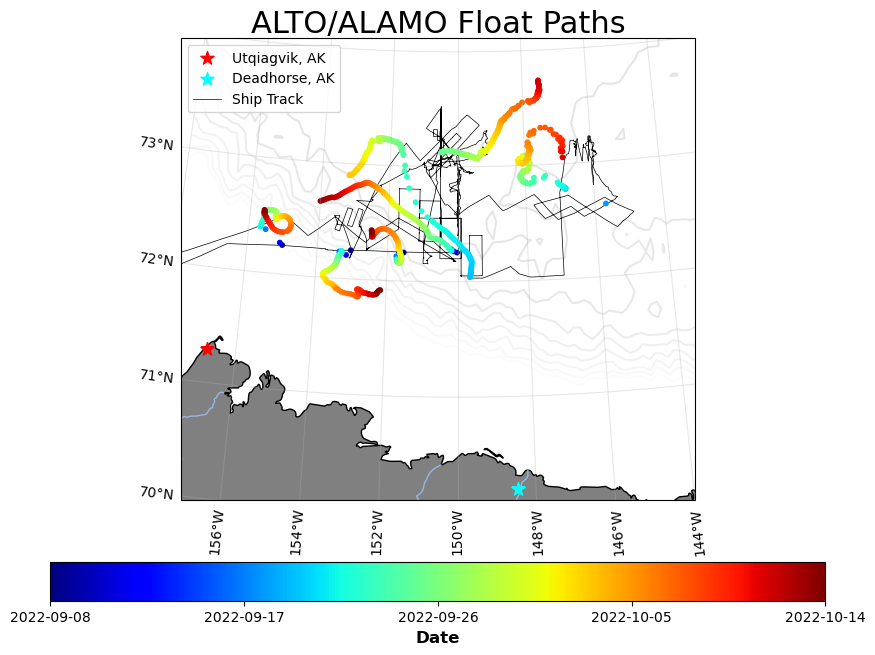

In [5]:
map_float_paths()

In [ ]:
##USE TO PLOT THE PROFILES TAKEN BY ANY GIVEN FLOAT 
def float_profiles(float_number,var):
    
    #GET FLOAT DATA
    file = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/ALAMO_ALTO/SASSIE_Fall_2022_ALAMO_ALTO_'+str(float_number)+'.nc'
    ds_float = xr.open_dataset(file)
    float_lat = ds_float['latitude']
    float_lon = ds_float['longitude']
    float_depth = ds_float['depth']
    float_var = ds_float[var]
    
    [lat,depth] = np.meshgrid(float_lat,float_depth)
    [lon,depth] = np.meshgrid(float_lon,float_depth)
    
    
    ##CREATE 3D PLOT 
    colormap,var_label = define_variable_attributes(var)

    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    latmin = min(float_lat.values)
    latmax = max(float_lat.values)
    lonmin = min(float_lon.values)
    lonmax = max(float_lon.values)
    dmin = min(float_depth.values)
    dmax = max(float_depth.values)+0.5
    
      
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False    
    
    ax.set_title('ALTO/ALAMO'+' '+var_label+' '+'Readings from Float '+str(float_number),fontsize=15,pad=None)

    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    zticks = list(np.linspace(dmin,dmax,4))
    ax.set_zticks(np.around(zticks,2))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (m)')
    ax.view_init(210,60)

        
    ##APPLY FLOAT DATA   
    a = ax.scatter(lon,lat,depth,c=(float_var.values),cmap = colormap,s=2,zorder=1)    
    fig.colorbar(a,label = var_label)
    
    ##ADD BLACK AT TOP OF EACH PROFILE FOR CLARITY
    b = ax.plot(float_lon,float_lat,linewidth=2,
                 color='black',label = 'Float Path',zorder=1)
    
    plt.legend()
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+var+'/'):
        os.makedirs(fig_dir+var+'/')
    
    print('Saving Output Image:  '+fig_dir+var+'/'+'ALTO_ALAMO_'+var+'_Float_'+str(float_number)+'.png')
    plt.savefig(fig_dir+var+'/'+'ALTO_ALAMO_'+var+'_Float_'+str(float_number)+'.png',dpi='figure',format='png')
    

In [ ]:
float_profiles(11132,'temperature')
float_profiles(11133,'temperature')
float_profiles(11136,'temperature')
float_profiles(9097,'temperature')
float_profiles(9098,'temperature')
float_profiles(9101,'temperature')
float_profiles(11131,'temperature')

In [ ]:
float_profiles(11132,'salinity')
float_profiles(11133,'salinity')
float_profiles(11136,'salinity')
float_profiles(9097,'salinity')
float_profiles(9098,'salinity')
float_profiles(9101,'salinity')
float_profiles(11131,'salinity')

In [ ]:
##PLOT TEMP/SALINITY PROFILE FROM A GIVEN FLOAT CLOSEST TO A GIVEN TIME: 
def plot_float_profile_by_date(float_number,time):
    
    #GET ALL FLOAT DATA
    file = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/ALAMO_ALTO/SASSIE_Fall_2022_ALAMO_ALTO_'+str(float_number)+'.nc'
    ds_float = xr.open_dataset(file)
    float_time = ds_float['time'].astype('int64')
    
    ##FIND THE CLOSES TIME TO THE TIME SPECIFIED
    time_difference = abs((float_time.values)-np.datetime64(time,'ns').astype('int64'))
    cast_indx = np.squeeze(np.where(time_difference == min(time_difference)))
    
    #PULL OUT LAT,LON,TIME,AND DATA OF CAST
    cast_time = ds_float['time'].values[cast_indx]
    float_lat = ds_float['latitude'].values[cast_indx]
    float_lon = ds_float['longitude'].values[cast_indx]
    float_depth = ds_float['depth'].values
    float_temp = ds_float['temperature'].values[:,cast_indx]
    float_sal = ds_float['salinity'].values[:,cast_indx]
    
    
    ## PLOT THE DATA
    fig,ax1 = plt.subplots()
    ax2 = ax1.twiny()
    ax1.plot(float_temp,float_depth,linewidth=0.4,c='blue')
    ax1.invert_yaxis()
    ax1.set_xlabel('Temperature ($^{\circ}$C)',color = 'blue')
    ax1.set_ylabel('Depth (m)')
    ax2.plot(float_sal,float_depth,linewidth=0.4,c='red')
    ax2.set_xlabel('Salinity',color ='red')
    fig.suptitle('ALTO/ALAMO Float '+str(float_number)+' Salinity and Temperature Profile on '+str(pd.to_datetime(cast_time).year).zfill(2)+'/'+str(pd.to_datetime(cast_time).month).zfill(2)+'/'+str(pd.to_datetime(cast_time).day).zfill(2)+' at '+str(pd.to_datetime(cast_time).hour).zfill(2)+':'+str(pd.to_datetime(cast_time).minute).zfill(2)+':'+str(pd.to_datetime(cast_time).second).zfill(2)+'\n'+str(float_lat)+' $^{\circ}$N, '+str(float_lon)+' $^{\circ}$E',y=1.05)
    
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+'profiles/'):
        os.makedirs(fig_dir+'profiles/')
    print('Saving Output Image:  '+fig_dir+'profiles/'+'float'+str(float_number)+'_profile_'+str(pd.to_datetime(cast_time).year)+str(pd.to_datetime(cast_time).month).zfill(2)+str(pd.to_datetime(cast_time).day).zfill(2)+str(pd.to_datetime(cast_time).hour).zfill(2)+str(pd.to_datetime(cast_time).minute).zfill(2)+str(pd.to_datetime(cast_time).second).zfill(2)+'.png')
    plt.savefig(fig_dir+'profiles/'+'float'+str(float_number)+'_profile_'+str(pd.to_datetime(cast_time).year)+str(pd.to_datetime(cast_time).month).zfill(2)+str(pd.to_datetime(cast_time).day).zfill(2)+str(pd.to_datetime(cast_time).hour).zfill(2)+str(pd.to_datetime(cast_time).minute).zfill(2)+str(pd.to_datetime(cast_time).second).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')



In [ ]:
plot_float_profile_by_date(9101,'2022-09-21T03:30')
